In [1]:
import math
import numpy as np
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [
    tf.constant(x, dtype=tf.float32) for x in [true_w, features, 
                                               poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 0.4332199 ],
        [-0.05857562]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00,  4.3321991e-01,  9.3839742e-02,  1.3551082e-02,
          1.4676496e-03,  1.2716300e-04,  9.1815909e-06,  5.6823546e-07,
          3.0771364e-08,  1.4811964e-09,  6.4168379e-11,  2.5271835e-12,
          9.1235518e-14,  3.0403879e-15,  9.4082610e-17,  2.7172306e-18,
          7.3572403e-20,  1.8748840e-21,  4.5124283e-23,  1.0288810e-24],
        [ 1.0000000e+00, -5.8575623e-02,  1.7155517e-03, -3.3496501e-05,
          4.9051960e-07, -5.7464979e-09,  5.6100784e-11, -4.6944832e-13,
          3.4372783e-15, -2.2371191e-17,  1.3104063e-19, -6.9779879e-22,
          3.4061665e-24, -1.5347563e-26,  6.4213790e-29, -2.5075751e-31,
          9.1801728e-34, -3.1631431e-36,  1.0293504e-38, -3.1733805e-41]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.3737607, 4.806911 ], dtyp

In [4]:
def evalute_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for x, y in data_iter:
        l = loss(net(x), y)
        metric.add(tf.reduce_sum(l), tf.size(l))
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, 
         num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    inputs_shape = train_features.shape[-1]
    
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels), batch_size)
    test_iter = load_array((test_features, test_labels), batch_size, 
                          is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                       xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                       legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), 
                                    evalute_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def use_svg_display():
    display.set_matplotlib_formats('svg')

def train_epoch_ch3(net, train_iter, loss, updater):
    metric = Accumulator(3)
    for X, y in train_iter:
        with tf.GradientTape() as tape:
            y_hat = net(X)
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    return metric[0] / metric[2], metric[1] / metric[2]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l))
    return metric[0] / metric[1]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

weight: [[ 4.965838   1.2080452 -3.3797133  5.584625 ]]


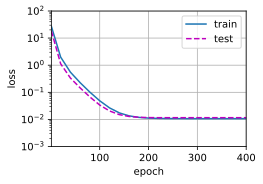

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
     labels[:n_train], labels[n_train:])

weight: [[3.2288284 4.0692143]]


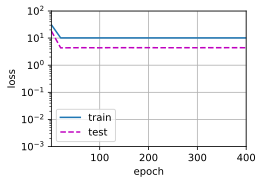

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
     labels[:n_train], labels[n_train:])

weight: [[ 4.9650373   1.309713   -3.3888772   5.0528293  -0.01964807  1.4905561
   0.37923303 -0.36226216 -0.25684538  0.25413013 -0.4795639  -0.41781232
   0.52803266 -0.12667039  0.5244915   0.10293145  0.46062458  0.1564331
   0.44135177 -0.17681292]]


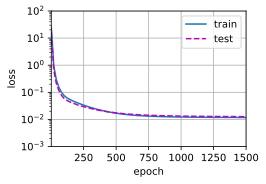

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :], 
     labels[:n_train], labels[n_train:], num_epochs=1500)